In [ ]:
import torch        #kütüphaneler
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')   #GPU varsa kullan
print(f"Kullanılan Cihaz: {device}")

torch.manual_seed(42)   #Rastgelelik için sabit tohum

Kullanılan Cihaz: cuda


Gerekli kütüphaneleri import ettiğimiz bölüm. Ayrıca sabit tohumu bu hücrede belirledim.

In [ ]:
import pandas as pd     #veri yükleme
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

train_csv_path = r'C:\Users\Efe\Desktop\archive\Training_Set\Training_Set\RFMiD_Training_Labels.csv'
val_csv_path   = r'C:\Users\Efe\Desktop\archive\Evaluation_Set\Evaluation_Set\RFMiD_Validation_Labels.csv'
test_csv_path  = r'C:\Users\Efe\Desktop\archive\Test_Set\Test_Set\RFMiD_Testing_Labels.csv'

train_img_dir = r'C:\Users\Efe\Desktop\archive\Training_Set\Training_Set\Training' 
val_img_dir   = r'C:\Users\Efe\Desktop\archive\Evaluation_Set\Evaluation_Set\Validation'   
test_img_dir  = r'C:\Users\Efe\Desktop\archive\Test_Set\Test_Set\Test'

class RFMiDDataset(Dataset):    #veri okuma
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_id = str(self.data_frame.iloc[idx, 0]) # İlk sütun ID

        img_name = f"{img_id}.png"
        img_path = os.path.join(self.root_dir, img_name)

        if not os.path.exists(img_path):
             img_name = f"{img_id}.jpg"
             img_path = os.path.join(self.root_dir, img_name)

        try:        # 2. Resmi Yükle
            image = Image.open(img_path).convert('RGB')
        except (FileNotFoundError, OSError):
            print(f"Uyarı: Resim bulunamadı -> {img_path}")
            image = Image.new('RGB', (256, 256), (0, 0, 0))

        label = int(self.data_frame.iloc[idx, 1]) 

        if self.transform:
            image = self.transform(image)

        return image, label

# Dönüşümler
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Veri Setlerini Oluştur
train_dataset = RFMiDDataset(csv_file=train_csv_path, root_dir=train_img_dir, transform=transform)
val_dataset   = RFMiDDataset(csv_file=val_csv_path,   root_dir=val_img_dir,   transform=transform)
test_dataset  = RFMiDDataset(csv_file=test_csv_path,  root_dir=test_img_dir,  transform=transform)

# DataLoader'ları Oluştur
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)

print(f"Eğitim Verisi: {len(train_dataset)} adet")
print(f"Test Verisi:   {len(test_dataset)} adet")
print("Sınıflar: 0 (Sağlıklı), 1 (Hastalık Riski Var)")

Eğitim Verisi: 1920 adet
Test Verisi:   640 adet
Sınıflar: 0 (Sağlıklı), 1 (Hastalık Riski Var)


## HÜCRE 2: Veri Yükleme, Ön İşleme ve Hazırlık
Bu hücre, projenin **lojistik merkezidir**. Dağınık haldeki ham verileri (Resim dosyaları ve CSV etiketleri), yapay zeka modelinin işleyebileceği matematiksel formata (Tensor) dönüştürür.

Bu hücrede gerçekleşen temel işlemler şunlardır:

### 1. Dosya Yollarının Tanımlanması
Eğitim, Doğrulama ve Test setleri için gerekli olan **CSV (Etiket)** dosyalarının ve **Resim Klasörlerinin** bilgisayardaki konumları sisteme tanıtılır.

### 2. Özel Veri Okuyucu (`class RFMiDDataset`)
RFMiD veri seti standart klasör yapısında olmadığı için özel bir `Dataset` sınıfı yazılmıştır. Bu sınıfın görevleri:
* **Eşleştirme:** CSV dosyasındaki `ID` numarasını okuyup ilgili klasördeki resim dosyasıyla (.png veya .jpg) eşleştirir.
* **Hata Yönetimi:** Eğer bir resim dosyası bozuksa veya bulunamazsa, kodun çökmesini engellemek için siyah (boş) bir kare üretir.
* **Etiketleme:** İlgili resmin `Disease_Risk` sütununa bakarak **0 (Sağlıklı)** veya **1 (Hasta)** etiketini atar.

### 3. Görüntü Dönüşümleri (`transforms`)
Resimler modele girmeden önce standart hale getirilir:
* **Resize:** Tüm resimler **256x256** piksel boyutuna getirilir.
* **ToTensor:** Resimler matematiksel matrislere (0-1 arası sayılara) çevrilir.
* **Normalize:** Renk değerleri belirli bir aralığa sıkıştırılarak modelin daha hızlı öğrenmesi sağlanır.

### 4. Veri Paketleme (`DataLoaders`)
Veriler RAM'i şişirmemek için **32'şerli paketler (Batch)** halinde modele sunulur.
* **Shuffle (Karıştırma):** Sadece eğitim setinde veriler her epoch başında karıştırılır. Bu, modelin resim sırasını ezberlemesini önler ve gerçek öğrenmeyi teşvik eder.

In [30]:
class BasicCNN(nn.Module):      #basic cnn modeli
    def __init__(self, num_classes=4):
        super(BasicCNN, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 32 * 32, 512), 
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model_basic = BasicCNN(num_classes=2).to(device)
print("Basic CNN Modeli oluşturuldu.")

Basic CNN Modeli oluşturuldu.


## HÜCRE 3: Basic CNN Model Mimarisi
Bu hücrede, retina görüntülerini sınıflandırmak için **Evrişimli Sinir Ağı (Convolutional Neural Network - CNN)** mimarisi tasarlanmaktadır. Modelimiz 3 ana bloktan oluşan bir özellik çıkarıcı ve bir sınıflandırıcıdan meydana gelir.

Modelin çalışma mantığı iki aşamalıdır:

### 1. Özellik Çıkarıcı (`self.features`) - "Göz" Kısmı
Bu kısım, resimdeki kenarları, dokuları ve hastalık belirtilerini tespit eder. Resim boyutu her adımda yarıya düşürülürken, derinlik (özellik sayısı) artırılır.
* **Giriş:** 256x256 boyutunda renkli (3 kanallı) resim.
* **1. Blok:** 32 farklı filtre uygular. Boyut 128x128'e düşer.
* **2. Blok:** 64 farklı filtre uygular. Boyut 64x64'e düşer.
* **3. Blok:** 128 farklı filtre uygular. Boyut 32x32'ye düşer.
* **Mantık:** `Conv2d` desenleri yakalar, `ReLU` negatif değerleri temizler, `MaxPool2d` resmi küçülterek işlem yükünü azaltır ve önemli özellikleri belirginleştirir.

### 2. Sınıflandırıcı (`self.classifier`) - "Beyin" Kısmı
Özellik çıkarıcıdan gelen matris verisi, düz bir vektöre çevrilip karar mekanizmasına sokulur.
* **Flatten:** 3 boyutlu matrisi (128 kanal x 32 yükseklik x 32 genişlik) tek boyutlu uzun bir listeye çevirir.
* **Linear (Tam Bağlı Katmanlar):** Nöronların birbiriyle tam bağlantı kurarak karar verdiği kısımdır.
* **Dropout (0.5):** Eğitim sırasında nöronların %50'sini rastgele kapatarak modelin **ezberlemesini (overfitting)** engeller.
* **Son Çıktı:** `num_classes=2` parametresi ile modelin sonucunda 2 adet çıktı hücresi (Sağlıklı / Hasta) üretilir.



**Not:** Model, RFMiD veri setimizdeki "Hastalık Var/Yok" ayrımına uygun olarak **2 sınıflı** çalışacak şekilde başlatılmıştır (`num_classes=2`).

In [31]:
import time     #eğitim fonksiyonu  

def train_model(model, criterion, optimizer, num_epochs=5):
    start_time = time.time()
    
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
                dataloader = train_loader
            else:
                model.eval()   
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device) 
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'train':
                train_acc_history.append(epoch_acc.item())
                train_loss_history.append(epoch_loss)
            else:
                val_acc_history.append(epoch_acc.item())
                val_loss_history.append(epoch_loss)

    end_time = time.time() - start_time
    print(f'Eğitim tamamlandı. Toplam süre: {end_time // 60:.0f}dk {end_time % 60:.0f}sn')

    return train_acc_history, val_acc_history, train_loss_history, val_loss_history

## HÜCRE 4: Model Eğitim Fonksiyonu (Training Loop)
Bu hücre, modelin öğrenme sürecini yöneten **`train_model`** fonksiyonunu tanımlar. 

Fonksiyonun çalışma mantığı adım adım şöyledir:

### 1. Epoch Döngüsü (Dış Döngü)
Eğitim, belirlenen tur sayısı (`num_epochs`) kadar tekrar eder. Bir **Epoch**, modelin tüm veri setini (eğitim ve doğrulama resimlerini) baştan sona bir kez görmesi demektir.

### 2. Fazlar: Eğitim (Train) ve Doğrulama (Val)
Her epoch içinde iki aşama gerçekleşir:
* **Train Fazı:** Model öğrenmeye açıktır (`model.train()`). Cevapları tahmin eder, hatasını görür ve ağırlıklarını günceller (ders çalışır).
* **Val Fazı:** Model öğrenmeye kapalıdır (`model.eval()`). Sadece sınav olur. Ağırlık güncellemesi yapılmaz, sadece performans ölçülür.

### 3. Öğrenme Döngüsü (Batch Loop)
Veriler 32'şerli paketler (batch) halinde modele girer:
1.  **Forward Pass (İleri Yayılım):** Model resme bakar ve bir tahminde bulunur.
2.  **Loss Calculation (Hata Hesabı):** Tahmin ile gerçek etiket (`labels`) karşılaştırılır. `criterion` (CrossEntropy) aradaki farkı (hatayı) hesaplar.
3.  **Backward Pass (Geri Yayılım - Sadece Train Fazında):** Hesaplanan hata geriye doğru takip edilerek, hangi nöronun ne kadar hata yaptığı bulunur. 
4.  **Optimizer Step:** `optimizer.step()` komutu ile modelin ağırlıkları, hatayı azaltacak şekilde güncellenir.

### 4. İstatistik ve Kayıt
Her epoch sonunda, o turun ortalama hatası (`Loss`) ve doğruluk oranı (`Accuracy`) hesaplanıp ekrana yazdırılır. Bu değerler grafik çizimi için listelere (`history`) kaydedilir.

**Fonksiyon Çıktısı:** Eğitim bittiğinde; Eğitim ve Doğrulama setleri için Accuracy ve Loss geçmişini içeren 4 adet liste döndürülür.

In [32]:
criterion = nn.CrossEntropyLoss()

optimizer_basic = optim.Adam(model_basic.parameters(), lr=0.001)    # optimizasyon algoritması

print("Basic CNN Modeli Eğitiliyor... ")    #Eğitimi Başlat

num_epochs = 5 

b_train_acc, b_val_acc, b_train_loss, b_val_loss = train_model(
    model_basic, 
    criterion, 
    optimizer_basic, 
    num_epochs=num_epochs
)

print("Basic CNN eğitimi tamamlandı.")

Basic CNN Modeli Eğitiliyor... 
Epoch 1/5
----------
train Loss: 0.5951 Acc: 0.7760
val Loss: 0.4761 Acc: 0.7906
Epoch 2/5
----------
train Loss: 0.4786 Acc: 0.7937
val Loss: 0.4573 Acc: 0.7984
Epoch 3/5
----------
train Loss: 0.4807 Acc: 0.7948
val Loss: 0.4330 Acc: 0.7984
Epoch 4/5
----------
train Loss: 0.4373 Acc: 0.8094
val Loss: 0.4361 Acc: 0.8172
Epoch 5/5
----------
train Loss: 0.4166 Acc: 0.8130
val Loss: 0.5004 Acc: 0.8016
Eğitim tamamlandı. Toplam süre: 35dk 19sn
Basic CNN eğitimi tamamlandı.


## HÜCRE 5: Eğitimin Başlatılması ve Hiperparametreler
Bu hücrede, modelin eğitimi için gerekli olan **"Oyun Kuralları" (Hiperparametreler)** belirlenir ve eğitim süreci resmen başlatılır.

Burada tanımlanan kritik bileşenler şunlardır:

### 1. Hata Fonksiyonu (`criterion`)
* **`nn.CrossEntropyLoss()`:** Sınıflandırma problemlerinde standart olarak kullanılan matematiksel formüldür.
* **Görevi:** Modelin yaptığı tahmin ile gerçek cevap arasındaki farkı (hatayı) hesaplar. Model "Hasta" olan bir resme "Sağlıklı" derse, bu fonksiyon yüksek bir ceza puanı (Loss) üretir.

### 2. Optimizasyon Algoritması (`optimizer`)
* **`optim.Adam`:** Modelin hatalarından ders çıkarmasını sağlayan algoritmadır.
* **`lr=0.001` (Learning Rate):** Öğrenme hızıdır. Modelin ağırlıklarını güncellerken atacağı adımın büyüklüğünü belirler. Çok büyük olursa model hata yapar, çok küçük olursa öğrenme çok uzun sürer.

### 3. Eğitimin Çalıştırılması
* **`num_epochs = 5`:** Modelin tüm veri setini kaç kez baştan sona göreceği belirlenir. (Test amaçlı 5 seçilmiştir, daha yüksek başarı için artırılabilir).
* **`train_model(...)`:** Önceki hücrede yazdığımız fonksiyon çağrılır ve eğitim başlar.
* **Sonuçların Kaydı:** Fonksiyonun döndürdüğü **Başarı (Accuracy)** ve **Hata (Loss)** değerleri; `b_train_acc`, `b_val_loss` gibi değişkenlere atanır. Bu veriler bir sonraki adımda grafik çizmek için kullanılacaktır.

In [ ]:
class DoubleConv(nn.Module):        #u-net modeli fonksiyonu
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNetClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super(UNetClassifier, self).__init__()
        
        self.inc = DoubleConv(3, 64)          # Giriş: 256x256
        self.down1 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(64, 128)               # 128x128
        )
        self.down2 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(128, 256)              # 64x64
        )
        self.down3 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(256, 512)              # 32x32
        )
    
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1)) # Çıktıyı 1x1 boyutuna indirir (RAM tasarrufu)
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.inc(x)
        x = self.down1(x)
        x = self.down2(x)
        x = self.down3(x) 
        x = self.avg_pool(x)
        x = self.fc(x)
        return x

model_unet = UNetClassifier(num_classes=2).to(device)

optimizer_unet = optim.Adam(model_unet.parameters(), lr=0.001)  # Optimizer tanımla

print("U-Net tabanlı Sınıflandırma Modeli oluşturuldu.")

U-Net tabanlı Sınıflandırma Modeli oluşturuldu.


## HÜCRE 6: U-Net Tabanlı Sınıflandırıcı Mimarisi
Bu hücrede, Basic CNN modelinden daha derin ve karmaşık bir yapı olan **U-Net** mimarisinin sınıflandırma için uyarlanmış hali tanımlanmaktadır.



Bu modelin farkı ve üstünlüğü şunlardır:

### 1. `DoubleConv` Bloğu (Yapı Taşı)
Modelin her katmanında standart bir işlem zinciri tanımlanmıştır:
* **Conv2d:** Özellik çıkarır.
* **BatchNorm2d (Batch Normalization):** Bu katman, öğrenmeyi inanılmaz derecede hızlandırır ve modelin daha kararlı çalışmasını sağlar (Basic CNN'de bu yoktu).
* **ReLU:** Aktivasyon fonksiyonu.
* **Tekrar:** Bu işlem bloğu arka arkaya 2 kez uygulanır ("Double" ismi buradan gelir). Bu sayede model her adımda daha detaylı özellikleri yakalar.

### 2. İniş Yolu (Encoder - `self.downX`)
Model, giriş görüntüsünü (256x256) adım adım küçültürken derinliğini (kanal sayısını) artırır:
* **Giriş:** 3 Kanal (Renk) -> 64 Özellik
* **Down1:** 128 Özellik (Boyut yarıya iner)
* **Down2:** 256 Özellik
* **Down3:** 512 Özellik (Boyut 32x32'ye iner)
Bu yapı, modelin hem ince detayları (damarlar) hem de genel yapıyı (göz yuvarlağı) öğrenmesini sağlar.

### 3. Akıllı Havuzlama (`AdaptiveAvgPool2d`)
Basic CNN'de `Flatten` yaparken tüm pikselleri tek tek düzleştirmiştik ve bu çok fazla RAM harcıyordu.
Burada **Adaptive Average Pooling** kullanılarak, son katmandaki 512 adet 32x32'lik harita, boyutu ne olursa olsun **1x1** boyutuna sıkıştırılır. Bu yöntem:
* RAM kullanımını ciddi oranda düşürür.
* Modelin resimdeki nesnenin (hastalığın) tam konumundan bağımsız olarak karar vermesini sağlar.

### 4. Karar Mekanizması (`self.fc`)
Sıkıştırılmış özellikler, Tam Bağlı Katmanlara (Linear) gönderilir ve son olarak `num_classes=2` parametresi ile **"Sağlıklı"** veya **"Hasta"** kararı verilir.

**Not:** Ayrıca bu hücrede bu modele özel bir **Optimizer** (`optimizer_unet`) tanımlanmıştır, böylece iki modelin eğitimi birbirine karışmaz.

In [39]:
print("U-Net Tabanlı Model Eğitimi Başlıyor...")    #u-net eğitimi başlat

num_epochs = 25

u_train_acc, u_val_acc, u_train_loss, u_val_loss = train_model(
    model_unet, 
    criterion, 
    optimizer_unet, 
    num_epochs=num_epochs
)

print("U-Net Eğitimi tamamlandı.")

U-Net Tabanlı Model Eğitimi Başlıyor...
Epoch 1/25
----------
train Loss: 0.4534 Acc: 0.7974
val Loss: 0.5190 Acc: 0.7906
Epoch 2/25
----------
train Loss: 0.4420 Acc: 0.8036
val Loss: 0.4583 Acc: 0.7906
Epoch 3/25
----------
train Loss: 0.4602 Acc: 0.8036
val Loss: 0.4745 Acc: 0.8172
Epoch 4/25
----------
train Loss: 0.4287 Acc: 0.8109
val Loss: 0.4291 Acc: 0.7906
Epoch 5/25
----------
train Loss: 0.4229 Acc: 0.8187
val Loss: 0.5766 Acc: 0.6609
Epoch 6/25
----------
train Loss: 0.4169 Acc: 0.8187
val Loss: 0.4637 Acc: 0.7906
Epoch 7/25
----------
train Loss: 0.4290 Acc: 0.8057
val Loss: 0.4742 Acc: 0.7328
Epoch 8/25
----------
train Loss: 0.4300 Acc: 0.8182
val Loss: 0.4204 Acc: 0.8172
Epoch 9/25
----------
train Loss: 0.4288 Acc: 0.8125
val Loss: 0.4234 Acc: 0.7875
Epoch 10/25
----------
train Loss: 0.4128 Acc: 0.8245
val Loss: 0.4754 Acc: 0.7906
Epoch 11/25
----------
train Loss: 0.4251 Acc: 0.8167
val Loss: 0.4323 Acc: 0.7906
Epoch 12/25
----------
train Loss: 0.4122 Acc: 0.8234
va

## HÜCRE 7: U-Net Modelinin Eğitimi (Uzun Metraj)
Bu hücrede, tasarladığımız **U-Net Classifier** modelini eğitiyoruz.

Buradaki en önemli fark, eğitim süresi yani **`num_epochs`** değeridir:

### 1. Neden 25 Epoch?
Basic CNN modeli 5 turda öğrenirken, U-Net için bu sayıyı **25'e** çıkardık.
* **Sebep:** U-Net, Basic CNN'e göre çok daha fazla parametreye (milyonlarca) ve katmana sahiptir. Bu kadar büyük bir yapının "ısınması", verideki desenleri kavraması ve optimum ayarlara ulaşması daha uzun sürer.
* **Beklenti:** İlk 5-10 epoch boyunca başarı oranı (Accuracy) düşük seyredebilir veya dalgalanabilir. Ancak sabırla beklendiğinde, uzun vadede Basic CNN'den daha yüksek bir doğruluk ve genelleme yeteneğine ulaşması beklenir.

### 2. Bağımsız Eğitim
Fonksiyona parametre olarak **`optimizer_unet`** gönderilir. Bu, Basic CNN'in öğrendiği bilgilerin karışmamasını, U-Net'in tamamen sıfırdan kendi yolunu çizmesini sağlar.

**Not:** Bu işlem, bilgisayarınızın donanım gücüne (GPU/CPU) bağlı olarak **zaman alabilir** (15 dakika ile birkaç saat arası).

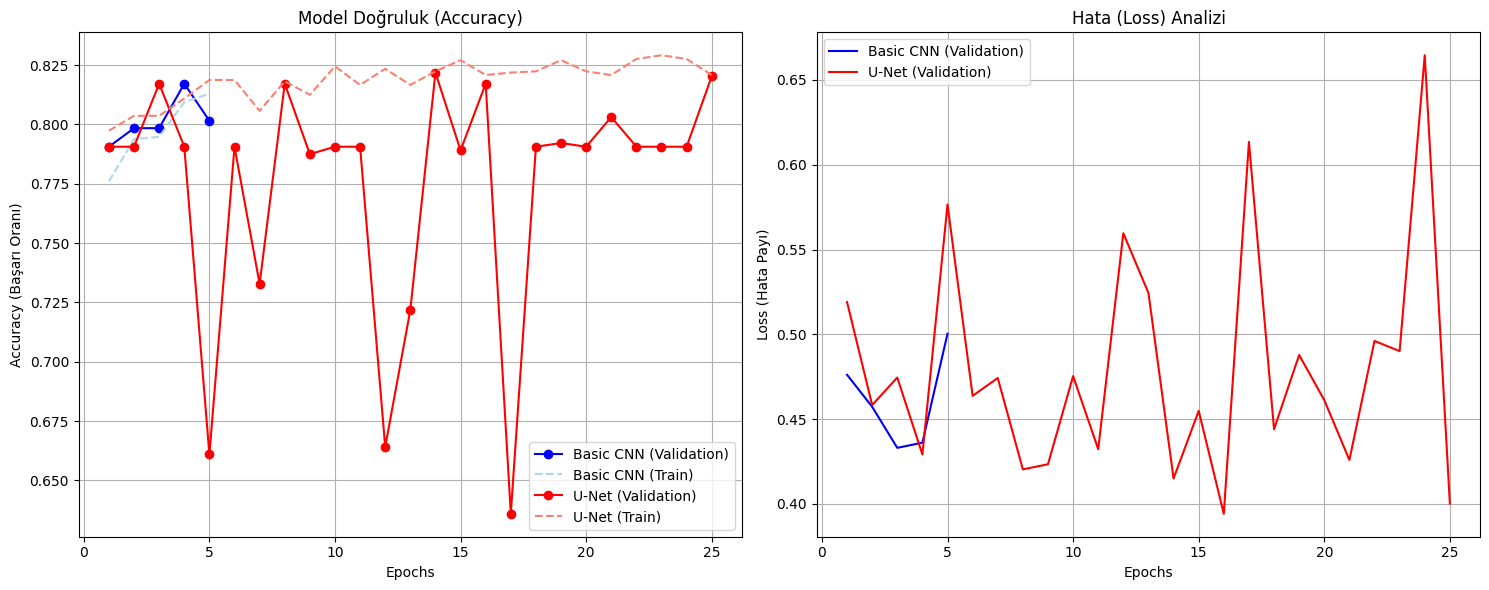

In [43]:
import matplotlib.pyplot as plt  #grafik çizimi

#epochs_range = range(1, len(b_val_acc) + 1)
epochs_b = range(1, len(b_val_acc) + 1)   # Basic CNN epochs
epochs_u = range(1, len(u_val_acc) + 1)   # U-Net epochs
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)    #GRAFİK 1: Doğruluk (Accuracy) Karşılaştırması

plt.plot(epochs_b, b_val_acc, label='Basic CNN (Validation)', color='blue', marker='o') # Basic CNN Çizgisi (Mavi)
plt.plot(epochs_b, b_train_acc, label='Basic CNN (Train)', color='lightblue', linestyle='--')

plt.plot(epochs_u, u_val_acc, label='U-Net (Validation)', color='red', marker='o')  # U-Net Çizgisi (Kırmızı)
plt.plot(epochs_u, u_train_acc, label='U-Net (Train)', color='salmon', linestyle='--')

plt.title('Model Doğruluk (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (Başarı Oranı)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)    # GRAFİK 2: Kayıp (Loss) Karşılaştırması
plt.plot(epochs_b, b_val_loss, label='Basic CNN (Validation)', color='blue')    # Basic CNN Kayıp (Mavi)
plt.plot(epochs_u, u_val_loss, label='U-Net (Validation)', color='red') # U-Net Kayıp (Kırmızı)

plt.title('Hata (Loss) Analizi')
plt.xlabel('Epochs')
plt.ylabel('Loss (Hata Payı)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## HÜCRE 8: Modellerin Karşılaştırmalı Analizi (Basic CNN vs U-Net)
Bu hücrede, eğitim süreçleri tamamlanan iki modelin performans geçmişleri (history) tek bir grafik üzerinde görselleştirilerek karşılaştırılır.

Bu grafikler, "Hangi model daha iyi?" sorusuna bilimsel cevap vermemizi sağlar:

### Renk Kodları
* 🔵 **Mavi Çizgiler:** Basic CNN Modelini temsil eder.
* 🔴 **Kırmızı Çizgiler:** U-Net Modelini temsil eder.

### 1. Grafik: Doğruluk (Accuracy) Karşılaştırması (Sol)
* **Amaç:** Hangi modelin teşhis koymada daha başarılı olduğunu gösterir.
* **Nasıl Okunmalı?** Çizgi ne kadar **yukarıdaysa** o kadar iyidir.
* **Kesik Çizgiler (--):** Eğitim (Train) başarısıdır. Modelin ders çalışırkenki performansıdır.
* **Düz Çizgiler (o):** Doğrulama (Validation) başarısıdır. Modelin sınavdaki performansıdır (Asıl önemli olan budur).
* **Yorum:** Eğer Kırmızı çizgi (U-Net) Mavi çizginin (CNN) üzerindeyse, U-Net daha başarılı demektir.

### 2. Grafik: Hata (Loss) Analizi (Sağ)
* **Amaç:** Modelin ne kadar "kendinden emin" ve hatasız olduğunu gösterir.
* **Nasıl Okunmalı?** Çizgi ne kadar **aşağıdaysa (sıfıra yakınsa)** o kadar iyidir.
* **Yorum:** Düşük Loss değeri, modelin sadece doğru bildiğini değil, aynı zamanda kararlarından emin olduğunu gösterir.



**Not:** Grafikte x ekseninin uzunluğu modellere göre değişebilir (Basic CNN 5 epoch, U-Net 25 epoch sürdüğü için çizgilerin uzunlukları farklı olacaktır).

Basic CNN için Metrikler Hesaplanıyor (Validation Set)...

=== Basic CNN BAŞARI RAPORU ===
Accuracy (Doğruluk):  %80.16
F1-Score:             0.7758
ROC AUC:              0.8080


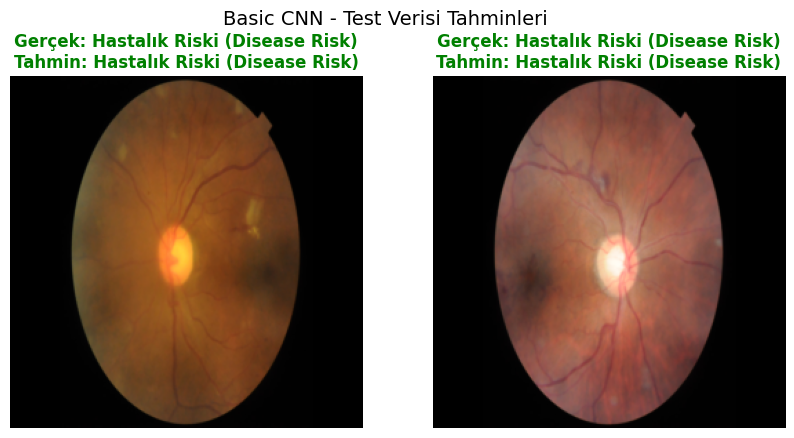

U-Net Classifier için Metrikler Hesaplanıyor (Validation Set)...

=== U-Net Classifier BAŞARI RAPORU ===
Accuracy (Doğruluk):  %82.03
F1-Score:             0.7675
ROC AUC:              0.8332


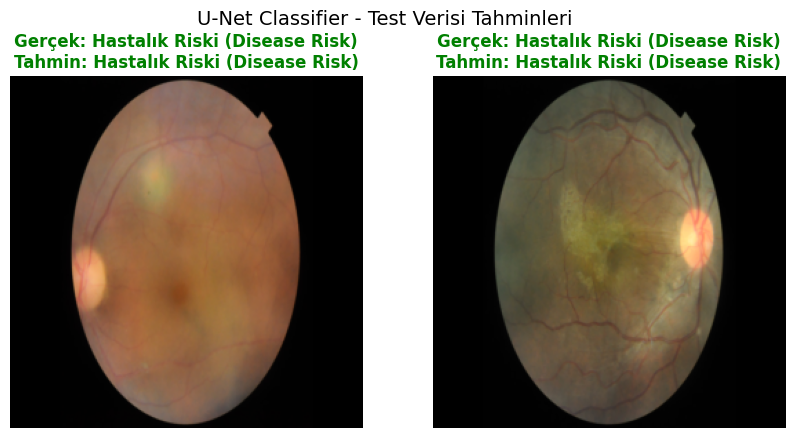

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt

class_names = ['Sağlıklı (Normal)', 'Hastalık Riski (Disease Risk)']    # 0: Hastalık Yok (Normal), 1: Hastalık Riski Var (Risk)

def calculate_metrics(model, model_name):   #METRİK HESAPLAMA FONKSİYONU
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = [] # Olasılıklar
    
    print(f"{model_name} için Metrikler Hesaplanıyor (Validation Set)...")
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            
            probs = F.softmax(outputs, dim=1)
            
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Numpy dizisine çevir
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    acc = accuracy_score(all_labels, all_preds) # Accuracy
    
    f1 = f1_score(all_labels, all_preds, average='weighted')    # F1 Score
    
    try:    # ROC AUC 
        auc = roc_auc_score(all_labels, all_probs[:, 1])
        auc_str = f"{auc:.4f}"
    except Exception as e:
        auc = 0.0
        auc_str = f"Hesaplanamadı ({e})"

    print(f"\n=== {model_name} BAŞARI RAPORU ===")
    print(f"Accuracy (Doğruluk):  %{acc*100:.2f}")
    print(f"F1-Score:             {f1:.4f}")
    print(f"ROC AUC:              {auc_str}")
    print("="*40)

def predict_on_test_folder(model, model_name):  # TEST KLASÖRÜNDEN GÖRSEL TAHMİN
    model.eval()
    try:
        # Test loader'dan bir paket veri al
        dataiter = iter(test_loader)
        images, labels = next(dataiter)
        
        # Batch size kontrolü
        current_batch_size = images.size(0)
        if current_batch_size == 0:
            print("Test verisi boş!")
            return

        # Rastgele 2 resim seç
        num_samples = min(2, current_batch_size)
        indices = random.sample(range(current_batch_size), num_samples)
        
        fig = plt.figure(figsize=(10, 5))
        fig.suptitle(f"{model_name} - Test Verisi Tahminleri", fontsize=14)
        
        for i, idx in enumerate(indices):
            ax = fig.add_subplot(1, 2, i+1)
            
            img_tensor = images[idx].unsqueeze(0).to(device)
            output = model(img_tensor)
            _, pred_idx = torch.max(output, 1)
            
            pred_label = class_names[pred_idx.item()]
            
            true_label_idx = labels[idx].item()
            true_label = class_names[true_label_idx]
            
            img = images[idx].cpu().numpy().transpose((1, 2, 0))
            img = img * 0.5 + 0.5 # Un-normalize
            plt.imshow(img)
            
            color = 'green' if pred_idx.item() == true_label_idx else 'red' # Renk Ayarı
            
            ax.set_title(f"Gerçek: {true_label}\nTahmin: {pred_label}", color=color, fontweight='bold')
            ax.axis('off')
        plt.show()
        
    except Exception as e:
        print(f"Görselleştirme sırasında hata: {e}")
        import traceback
        traceback.print_exc()

# --- MODELLERİ ÇALIŞTIR ---
calculate_metrics(model_basic, "Basic CNN")
predict_on_test_folder(model_basic, "Basic CNN")

calculate_metrics(model_unet, "U-Net Classifier")
predict_on_test_folder(model_unet, "U-Net Classifier")

## HÜCRE 9: Final Test ve Performans Raporlaması
Bu hücre, eğitilmiş olan modellerin (Basic CNN ve U-Net) daha önce hiç görmediği **Test Veri Seti** üzerindeki gerçek performansını ölçer ve raporlar.

Bu süreç iki aşamada gerçekleşir:

### 1. Sayısal Performans Ölçümü (`calculate_metrics`)
Modelin başarısı, literatürde kabul gören üç temel kriterle puanlanır:
* **Accuracy (Doğruluk):** Toplam resimlerin yüzde kaçını doğru bildi? (Genel başarı)
* **F1-Score:** Özellikle dengesiz veri setlerinde (hasta sayısı az, sağlıklı sayısı çok ise) modelin başarısını Accuracy'den daha iyi gösteren bir puandır.
* **ROC AUC:** Modelin hasta ile sağlıklı bireyi ayırt etme gücüdür. 0.5 yazı-tura demektir, 1.0 mükemmel demektir. 0.8 ve üzeri çok iyi kabul edilir.

### 2. Görsel Tahmin Testi (`predict_on_test_folder`)
Sadece sayılara güvenmek yerine, gözle görülür bir test yapılır:
* Test setinden rastgele 2 adet resim seçilir.
* Modeller bu resimlere bakar ve bir tahminde bulunur.
* **Sonuç Gösterimi:** Resmin üzerine **Gerçek Durum** ve modelin **Tahmini** yazılır.
    * Eğer tahmin doğruysa yazı **Yeşil**,
    * Yanlışsa **Kırmızı** renk olur.

Bu çıktı, projenin final sunumunda "Modelimiz şu resme baktı ve şu teşhisi koydu" diyebilmek için en önemli kanıttır.